In [718]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


### Data Load

In [719]:
X_train = np.load('data/X_train_regression2.npy')
X_train_df = pd.DataFrame(X_train)
y_train = np.load('data/y_train_regression2.npy')
y_train_df = pd.DataFrame(y_train, columns=['target'])
X_test = np.load('data/X_test_regression2.npy')
X_test_df = pd.DataFrame(X_test)

print(y_train_df)

      target
0  -0.508416
1  -1.069175
2  -0.065041
3   1.038245
4  -0.856277
..       ...
95 -0.878616
96  0.658198
97 -0.512486
98 -0.053755
99  0.494759

[100 rows x 1 columns]


### EDA

#### Data distribution analisys

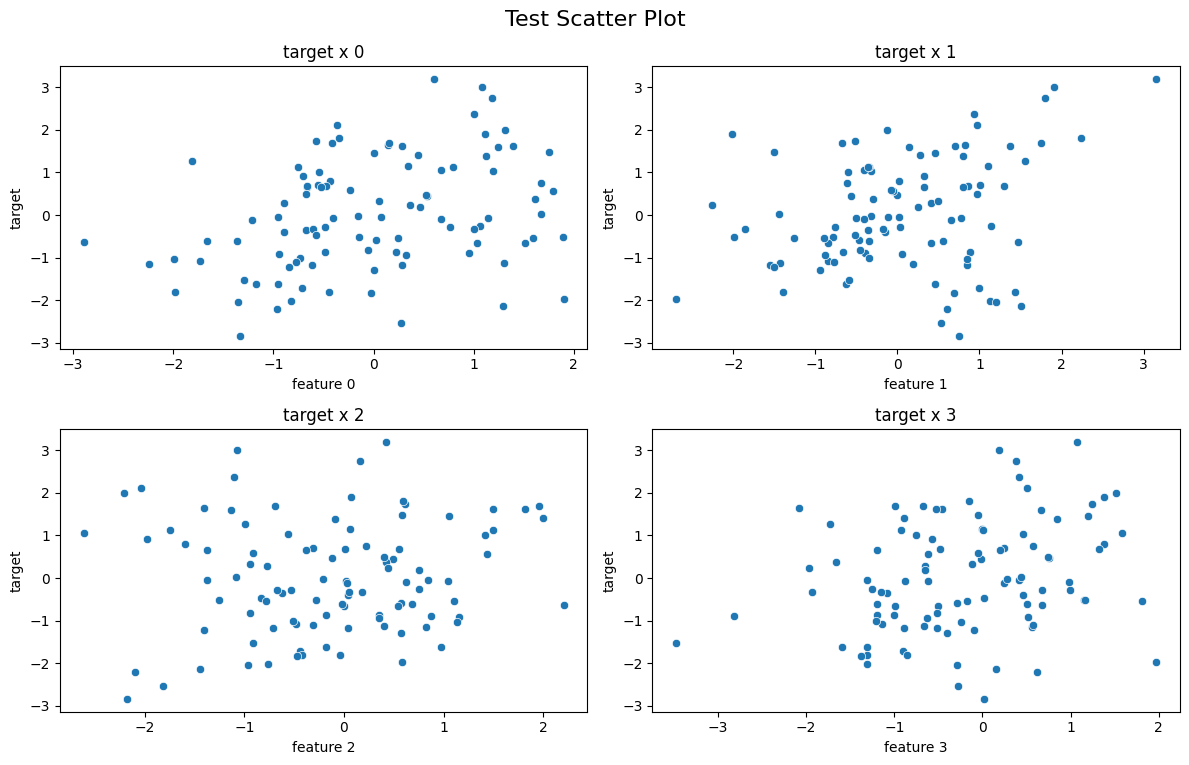

In [720]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

combined_df = pd.concat([X_train_df, y_train_df['target']], axis=1)

for i, feature in enumerate(X_train_df.columns):
    sns.scatterplot(data=combined_df, x=feature, y='target', ax=axes[i])
    axes[i].set_title(f'target x {feature}')
    axes[i].set_xlabel(f'feature {feature}')
    axes[i].set_ylabel('target')

fig.suptitle('Test Scatter Plot', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

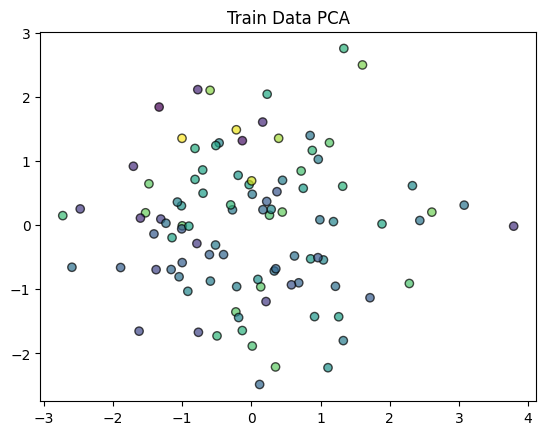

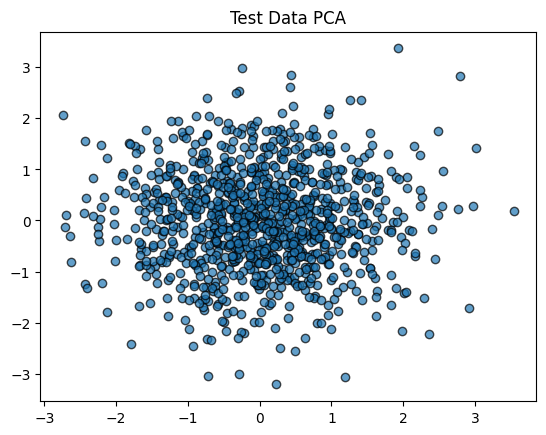

In [721]:
def plot_pca(train_data,train_target=None, title=''):
  pca = PCA(n_components=2)
  pca.fit(train_data)
  X_pca = pca.transform(train_data)
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_target, cmap=plt.cm.get_cmap('viridis'), edgecolor='k', alpha=0.7)
  plt.title(title)
  plt.show()

plot_pca(X_train_df, y_train_df['target'], title='Train Data PCA')
plot_pca(X_test_df, title='Test Data PCA')

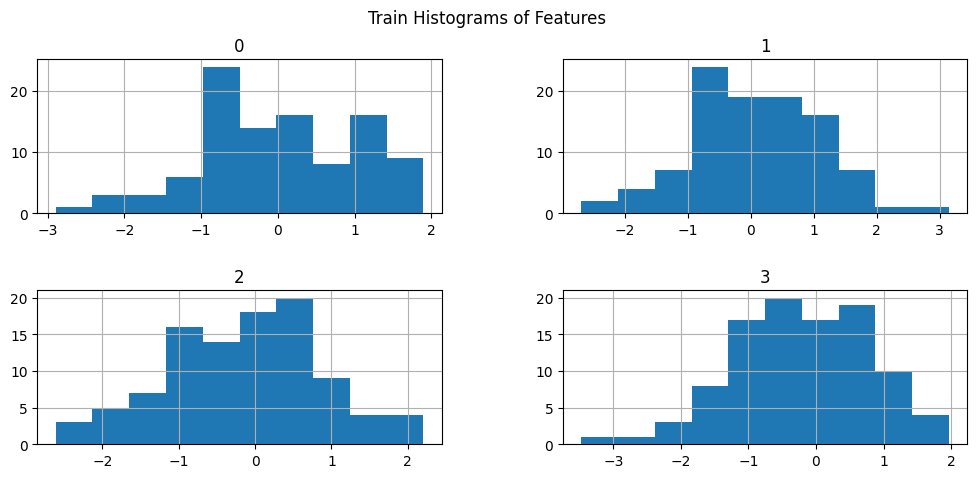

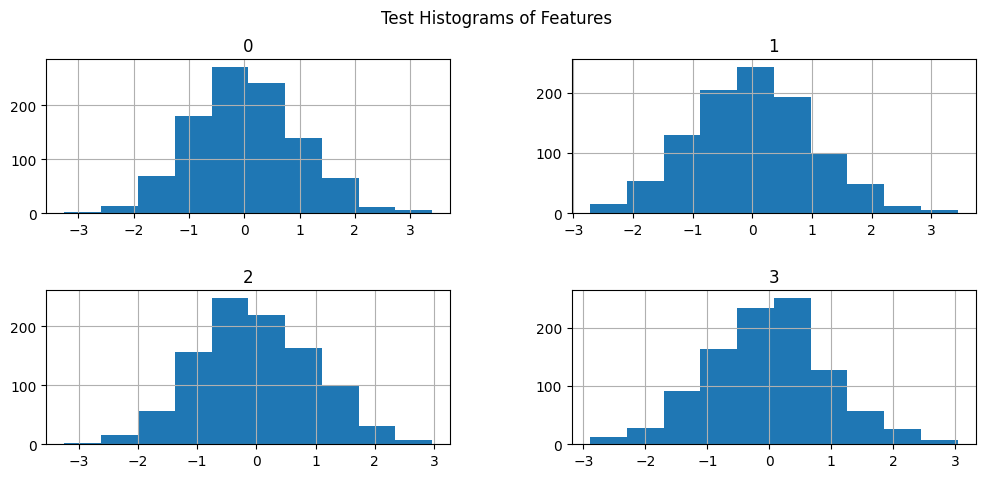

In [722]:
X_train_df.hist(bins=10, figsize=(12, 5))
plt.suptitle('Train Histograms of Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

X_test_df.hist(bins=10, figsize=(12, 5))
plt.suptitle('Test Histograms of Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

### Clustering

#### Gaussian Mixture Model

In [723]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X_train_df)

print(gmm.n_iter_)

20


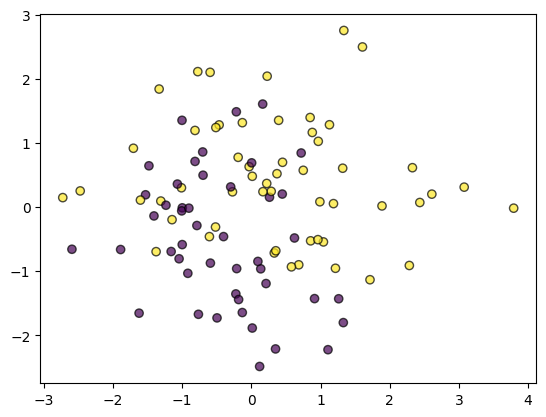

In [724]:
gmm_train_clusters = gmm.predict(X_train_df)
plot_pca(X_train_df, gmm_train_clusters)

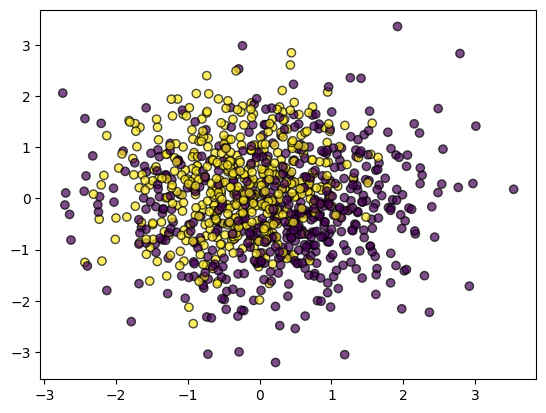

In [725]:
gmm_test_clusters = gmm.predict(X_test_df)
plot_pca(X_test_df, gmm_test_clusters)

#### KMeans

In [726]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train_df)

print(kmeans.n_iter_)

4


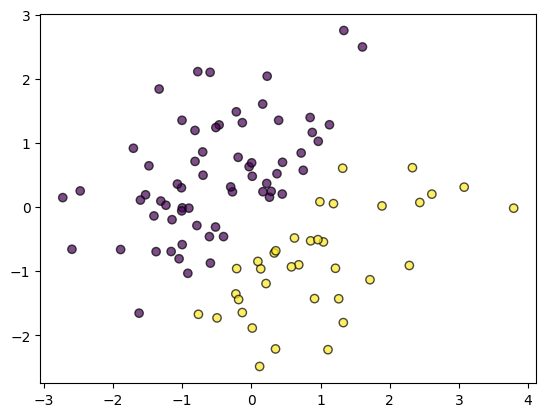

In [727]:
kmeans_train_clusters = kmeans.predict(X_train_df)
plot_pca(X_train_df, kmeans_train_clusters)

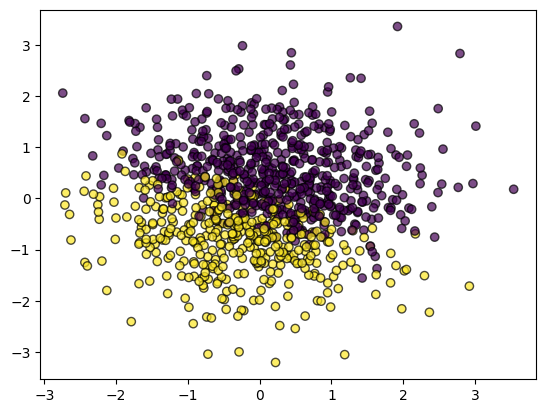

In [728]:
kmeans_test_clusters = kmeans.predict(X_test_df)
plot_pca(X_test_df, kmeans_test_clusters)

In [729]:
def split_dataset(X, clusters, y=None):
    mask1 = clusters == 0
    mask2 = clusters == 1

    X1 = X[mask1]
    X2 = X[mask2]
    if y is None:
        return X1, X2 
       
    y1 = y[mask1]
    y2 = y[mask2]
    
    return X1, X2, y1, y2


### Cross Validation

In [730]:
k_folds = 5
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
param_grid = {'alpha': alphas}

#### Lasso

In [731]:
def get_best_lasso(X, y):
    lasso = Lasso()

    grid_search = GridSearchCV(lasso, param_grid, cv=k_folds, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    best_lasso_alpha = grid_search.best_params_['alpha']
    best_lasso_score = -grid_search.best_score_

    print(f"Best Lasso Alpha: {best_lasso_alpha} -> Score: {best_lasso_score} MSE")
    return best_lasso_alpha, best_lasso_score

#### Ridge

In [732]:
def get_best_ridge(X, y):
    ridge = Ridge()

    grid_search = GridSearchCV(ridge, param_grid, cv=k_folds, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    best_ridge_alpha = grid_search.best_params_['alpha']
    best_ridge_score = -grid_search.best_score_

    print(f"Best Ridge Alpha: {best_ridge_alpha} -> Score: {best_ridge_score} MSE")
    return best_ridge_alpha, best_ridge_score

#### Ordinary Least Squares

In [733]:
def get_best_ols(X, y):
    linear_regression = LinearRegression()

    mse_scores = -cross_val_score(linear_regression, X, y, cv=k_folds, scoring='neg_mean_squared_error')
    lr_score = np.mean(mse_scores)

    print(f"OLS Score: {np.mean(lr_score)} MSE")
    return lr_score

#### Clustering Cross Validation Results

In [734]:
print("GMM Clustering CV Results")
X_train_1, X_train_2, y_train_1, y_train_2 = split_dataset(X_train_df, gmm_train_clusters, y_train_df)

print('\nDataset 1')
get_best_lasso(X_train_1, y_train_1)
get_best_ridge(X_train_1, y_train_1)
get_best_ols(X_train_1, y_train_1)

print('\nDataset 2')
get_best_lasso(X_train_2, y_train_2)
get_best_ridge(X_train_2, y_train_2)
get_best_ols(X_train_2, y_train_2)

print()

GMM Clustering CV Results

Dataset 1
Best Lasso Alpha: 0.1 -> Score: 1.5083002592174781 MSE


Best Ridge Alpha: 10.0 -> Score: 1.387976552285168 MSE
OLS Score: 1.559726944546096 MSE

Dataset 2
Best Lasso Alpha: 1.0 -> Score: 1.560625871183282 MSE
Best Ridge Alpha: 10.0 -> Score: 1.503226729504918 MSE
OLS Score: 1.5803770220894209 MSE



In [735]:
print("KMeans Clustering CV Results")
X_train_1, X_train_2, y_train_1, y_train_2 = split_dataset(X_train_df, kmeans_train_clusters, y_train_df)

print('\nDataset 1')
get_best_lasso(X_train_1, y_train_1)
get_best_ridge(X_train_1, y_train_1)
get_best_ols(X_train_1, y_train_1)

print('\nDataset 2')
get_best_lasso(X_train_2, y_train_2)
get_best_ridge(X_train_2, y_train_2)
get_best_ols(X_train_2, y_train_2)

print()

KMeans Clustering CV Results

Dataset 1
Best Lasso Alpha: 0.01 -> Score: 1.5719662709125204 MSE
Best Ridge Alpha: 10.0 -> Score: 1.5606566719567216 MSE
OLS Score: 1.5777958848054199 MSE

Dataset 2
Best Lasso Alpha: 0.01 -> Score: 1.0715413418230828 MSE
Best Ridge Alpha: 10.0 -> Score: 0.9769624495362985 MSE
OLS Score: 1.091764706855574 MSE



### Training

In [736]:
X_train_1, X_train_2, y_train_1, y_train_2 = split_dataset(X_train_df, gmm_train_clusters, y_train_df)

In [737]:
# model = Lasso(alpha=best_lasso_alpha)
# model.fit(X_train_df, y_train)

model1 = Ridge(alpha=10)
model1.fit(X_train_1, y_train_1)

model2 = Ridge(alpha=10)
model2.fit(X_train_2, y_train_2)

# model = LinearRegression()
# model.fit(X_train_df, y_train)

Ridge(alpha=10)

### Prediction

In [738]:
X_test_1, X_test_2 = split_dataset(X_test_df, gmm_test_clusters)

In [739]:
test_pred_1 = model1.predict(X_test_1)
test_pred_2 = model2.predict(X_test_2)

print(test_pred_1.shape)
print(test_pred_2.shape)

(515, 1)
(485, 1)


In [740]:
test_pred = np.empty_like(gmm_test_clusters, dtype=float)
test_pred[gmm_test_clusters == 0] = test_pred_1.reshape(-1)
test_pred[gmm_test_clusters == 1] = test_pred_2.reshape(-1)

test_pred = test_pred.reshape(-1, 1)
test_pred.shape

(1000, 1)

In [741]:
np.save('results/test_pred_task2.npy', test_pred)
y_test = np.load('results/test_pred_task2.npy')

print(y_test.shape)
print(y_test)

(1000, 1)
[[ 1.10540010e+00]
 [-1.92961764e-01]
 [ 6.47115586e-01]
 [ 6.96726977e-01]
 [ 1.89607413e-01]
 [ 6.10462467e-01]
 [-3.42660789e-01]
 [ 3.81923724e-01]
 [ 5.54792511e-01]
 [-2.32518351e-01]
 [-2.07636450e-01]
 [ 8.37948523e-02]
 [ 1.58525220e+00]
 [-5.37963650e-01]
 [ 1.48753383e-01]
 [-2.51835185e-01]
 [-4.04193984e-01]
 [ 9.09404425e-01]
 [ 9.86947742e-01]
 [ 4.22824101e-01]
 [-1.11762142e+00]
 [ 6.94385647e-01]
 [ 1.38211132e-01]
 [ 7.19486389e-01]
 [-5.93961779e-01]
 [ 1.02250385e+00]
 [ 3.77423334e-01]
 [ 9.55367445e-01]
 [ 2.97312046e-01]
 [-1.17486563e-01]
 [-6.68963314e-01]
 [-5.31535264e-01]
 [-6.45165729e-01]
 [ 1.64868115e-01]
 [ 1.40900743e+00]
 [ 5.37774683e-01]
 [-6.26159480e-02]
 [ 8.85964988e-01]
 [-4.35827685e-01]
 [-6.31624669e-01]
 [ 4.91482370e-01]
 [-2.56971204e-01]
 [ 8.41659424e-01]
 [-1.25182115e+00]
 [-6.20623768e-01]
 [-5.20106731e-02]
 [ 3.51408506e-01]
 [ 2.62120134e-01]
 [ 2.06097786e-01]
 [ 9.43572162e-01]
 [-7.07286088e-01]
 [ 5.24220708e-01]
 [